In [12]:
# Importing necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay


In [13]:
# Step 1: Load the Dataset
data = pd.read_csv('cybersecurity_attacks.csv')


In [14]:
# Step 2: Data Cleaning
# Drop columns with more than 50% missing values
threshold = 0.5 * len(data)
cleaned_data = data.dropna(thresh=threshold, axis=1)

# Drop irrelevant columns
irrelevant_columns = ['Payload Data', 'User Information', 'Device Information']
cleaned_data = cleaned_data.drop(columns=irrelevant_columns, errors='ignore')

# Encode categorical columns
categorical_columns = ['Severity Level', 'Traffic Type', 'Protocol', 'Action Taken', 'Log Source', 'Attack Type', 'Malware Indicators']
label_encoders = {}
for column in categorical_columns:
    le = LabelEncoder()
    cleaned_data[column] = le.fit_transform(cleaned_data[column].astype(str))
    label_encoders[column] = le

# Impute missing values
numerical_columns = cleaned_data.select_dtypes(include=['float64', 'int64']).columns
cleaned_data[numerical_columns] = cleaned_data[numerical_columns].fillna(cleaned_data[numerical_columns].median())

categorical_columns = cleaned_data.select_dtypes(include=['object']).columns
cleaned_data[categorical_columns] = cleaned_data[categorical_columns].fillna(cleaned_data[categorical_columns].mode().iloc[0])


In [15]:
# Standardize numerical features
scaler = StandardScaler()
numerical_columns = cleaned_data.select_dtypes(include=['float64', 'int64']).columns
cleaned_data[numerical_columns] = scaler.fit_transform(cleaned_data[numerical_columns])


In [16]:
# Step 3: Feature Selection and Train-Test Split
X = cleaned_data.drop(columns=["Severity Level", "Timestamp", "Source IP Address", "Destination IP Address", 
                                "Packet Type", "Attack Signature", "Network Segment", 
                                "Geo-location Data", "Proxy Information", "Firewall Logs"])
y = cleaned_data["Severity Level"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)


In [17]:
# Step 4: Train Models
# Initialize models
rf_model = RandomForestClassifier(random_state=0)
svm_model = SVC(kernel='rbf', random_state=0, probability=True)
log_reg_model = LogisticRegression(random_state=0, max_iter=500)


In [18]:
# Train and evaluate Random Forest
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)
rf_accuracy = accuracy_score(y_test, rf_pred)
rf_f1 = f1_score(y_test, rf_pred, average='weighted')


In [19]:
# Train and evaluate SVM
svm_model.fit(X_train, y_train)
svm_pred = svm_model.predict(X_test)
svm_accuracy = accuracy_score(y_test, svm_pred)
svm_f1 = f1_score(y_test, svm_pred, average='weighted')

In [20]:
# Train and evaluate Logistic Regression
log_reg_model.fit(X_train, y_train)
log_reg_pred = log_reg_model.predict(X_test)
log_reg_accuracy = accuracy_score(y_test, log_reg_pred)
log_reg_f1 = f1_score(y_test, log_reg_pred, average='weighted')


In [21]:
# Step 5: Results Summary
results = pd.DataFrame({
    "Model": ["Random Forest", "SVM", "Logistic Regression"],
    "Accuracy": [rf_accuracy, svm_accuracy, log_reg_accuracy],
    "F1 Score": [rf_f1, svm_f1, log_reg_f1]
})
print("Model Evaluation Results:")
print(results)


Model Evaluation Results:
                 Model  Accuracy  F1 Score
0        Random Forest   0.33000  0.329538
1                  SVM   0.32625  0.323282
2  Logistic Regression   0.32800  0.319876


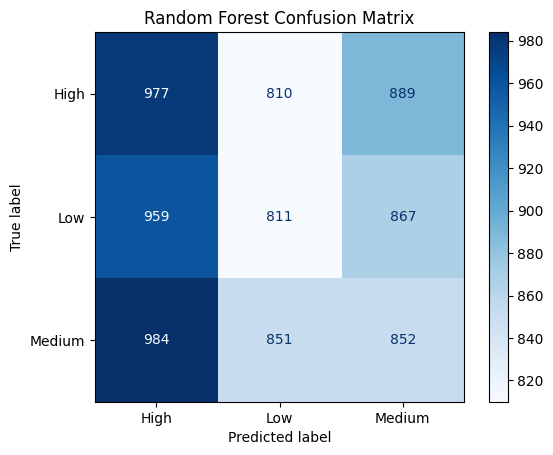

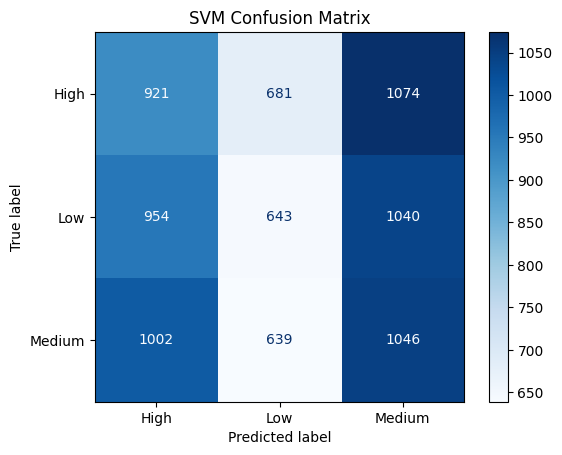

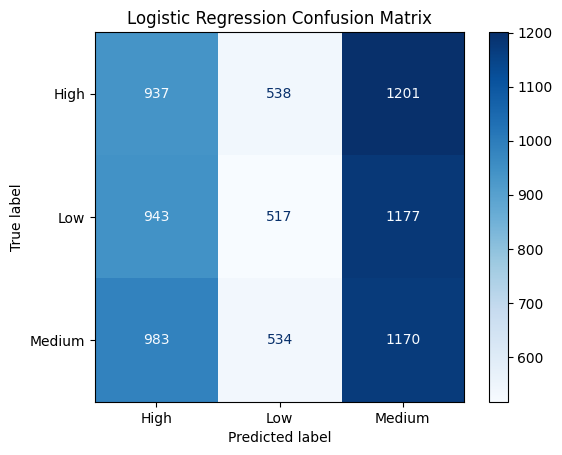

In [22]:
# Step 6: Plot Confusion Matrices
for model_name, pred in zip(
    ["Random Forest", "SVM", "Logistic Regression"],
    [rf_pred, svm_pred, log_reg_pred]
):
    cm = confusion_matrix(y_test, pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoders['Severity Level'].classes_)
    disp.plot(cmap="Blues")
    plt.title(f"{model_name} Confusion Matrix")
    plt.show()

In [23]:
# Step 7: Feature Importance (for Random Forest)
feature_importances = rf_model.feature_importances_
feature_importance_df = pd.DataFrame({
    "Feature": X.columns,
    "Importance": feature_importances
}).sort_values(by="Importance", ascending=False)
print("Feature Importances (Random Forest):")
print(feature_importance_df.head(10))


Feature Importances (Random Forest):
              Feature  Importance
6      Anomaly Scores    0.203798
0         Source Port    0.203515
1    Destination Port    0.203205
3       Packet Length    0.198358
4        Traffic Type    0.037446
2            Protocol    0.036573
8        Action Taken    0.036115
7         Attack Type    0.035390
9          Log Source    0.023618
5  Malware Indicators    0.021983


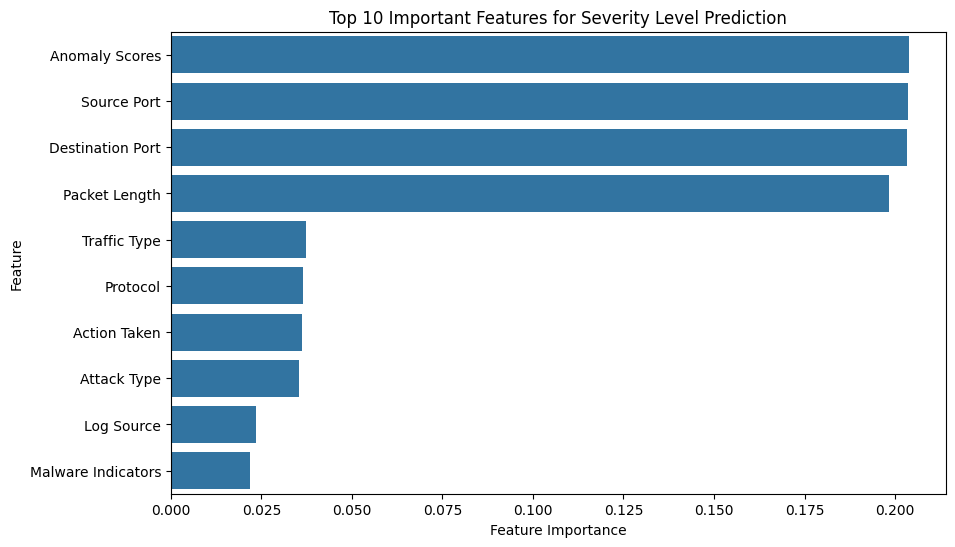

In [24]:
# Plot top 10 important features
plt.figure(figsize=(10, 6))
sns.barplot(x="Importance", y="Feature", data=feature_importance_df.head(10))
plt.title("Top 10 Important Features for Severity Level Prediction")
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.show()